# SIFT Implementation

By: Denny Alvito Ginting

This code is referenced from:
https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5

## Importing Libraries

In [ ]:
import cv2
import numpy as np
from numpy import round
import matplotlib.pyplot as plt
from functools import cmp_to_key

## Creating Scale Space as well as the Image Pyramids

### Generate Base Image

This process works by product a base image by upsampling it by 2 in both directions, and then will be blurred

In [ ]:
def generateBaseImage(img, sigma, blur):

  # Resize Image with Interpolation (So that the resized pixel will take
  # the neighborhoods' pixel)
  img = cv2.resize(img, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
  sigma_diff = np.sqrt(max((sigma)**2 - ((2*blur)**2), 0.01))

  # Blur the result (image blurred from sigma instead of input assumed blur)
  return cv2.GaussianBlur(img, (0,0), sigmaX=sigma_diff, sigmaY=sigma_diff)

## Computing Number Of Octaves

This process works by computing `number of times` we can repeatedly `halve` an image until it bacomes too small.

In [ ]:
def computeNumberOfOctaves(img_shape):
  """
  Smallest image is atleast 1 pixel, so we have formula of
  y/(2^x) = 1

  to solve x, we have this formula
  log(y)/log(2)

  (- 1) -> to floor (round) the value so that we have an 
  integer number of layers in image pyramid

  """

  return int(round(np.log(min(img_shape)) / np.log(2) - 1))

## Gaussian Kernels

We will generate list of `Gaussian Kernels` which we will use to blur the `input image`

In [ ]:
def generateGaussianKernels(sigma, num_intervals):
  num_of_images_per_octave = num_intervals + 3
  k = 2 ** (1. / num_intervals)

  """
  Create a scale of gaussian blur so blur one blur scale to the next
  blur scale within an octave

  The result of this gaussian kernels is basically blurring an input image
  repeatedly computed gaussian kernels size to produce a new image
  and finally reached a new scale (increasing octave with more blur in 
  the image)

  """
  gaussian_kernels = np.zeros(num_of_images_per_octave)
  gaussian_kernels[0] = sigma

  # Repetition to cover all blur steps when subtracting the images
  for idx in range(1, num_of_images_per_octave):
    sigma_prev = (k**(idx-1)) * sigma
    sigma_total = k * sigma_prev
    gaussian_kernels[idx] = np.sqrt(sigma_total**2 - sigma_prev**2)

  return gaussian_kernels

## Generate Gaussian Image

This process mainly is to create `Image Pyramids` using our base image and after blur the image with our `gaussian kernels`

In [ ]:
def generateGaussianImages(img, num_octaves, gaussian_kernels):
  """
  Generating a image pyramid from the gaussian kernels
  
  """
  gaussian_images = []

  for octave_idx in range(num_octaves):
    gaussian_img_in_octave = []

    # This first image in octave is already the correct blur
    gaussian_img_in_octave.append(img)

    for gaussian_kernel in gaussian_kernels[1:]:
      # We blur the image with sigma value from our gaussian kernels
      img = cv2.GaussianBlur(img, 
                               (0, 0), 
                               sigmaX=gaussian_kernel,
                               sigmaY=gaussian_kernel)
      gaussian_img_in_octave.append(img)
    
    gaussian_images.append(gaussian_img_in_octave)

    """
    Create the octave base

    We take the half value by the third-to-last image
    since it contains the appropriate blur value

    """
    octave_base = gaussian_img_in_octave[-3]
    img = cv2.resize(octave_base, 
                     (int(octave_base.shape[1] / 2),
                      int(octave_base.shape[0] / 2)),
                      interpolation=cv2.INTER_NEAREST)
  
  return np.array(gaussian_images)

## Generate Difference Of Gaussian Images

This process will compute the image by subtracting successive pairs of the Gaussian-blurred images

In [ ]:
def generateDoGImages(gaussian_images):
  dog_images = []

  for gaussian_images_in_octave in gaussian_images:
    dog_images_in_octave = []

    for image_1, image_2 in zip(gaussian_images_in_octave,
                                gaussian_images_in_octave[1:]):
      
      # Subtract image 2 with image 1
      dog_images_in_octave.append(cv2.subtract(image_2, image_1))
    
    dog_images.append(dog_images_in_octave)
  
  return np.array(dog_images)

## Visualization

We will try to plot the image using the third layer of the `Gaussian Pyramid`

In [ ]:
img = cv2.imread('/content/object.jpg', 0)
img = img.astype('float32')

sigma = 1.6
blur = 0.5
num_intervals = 3

base_img = generateBaseImage(img, sigma, blur)
num_octaves = computeNumberOfOctaves(base_img.shape)
gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
gaussian_images = generateGaussianImages(base_img, num_octaves, gaussian_kernels)
dog_images = generateDoGImages(gaussian_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


### Gaussian Image

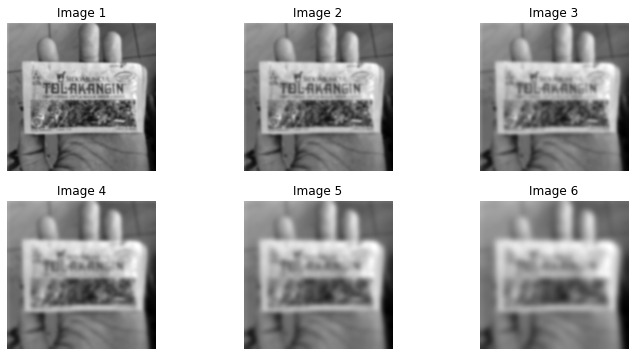

In [ ]:
plt.figure(figsize=(12,6))
idx = 1
for pic in gaussian_images[2]:
  plt.subplot(2, len(gaussian_images[2])/2, idx)
  plt.title(f'Image {idx}')
  idx+=1
  plt.imshow(pic, cmap='gray')
  plt.axis('off')

plt.show()

### Difference Of Gaussian Images

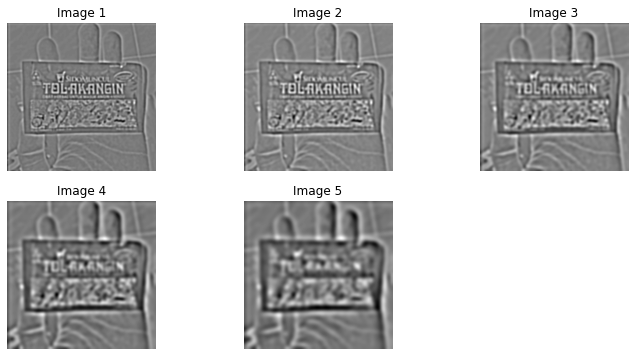

In [ ]:
plt.figure(figsize=(12,6))
idx = 1
for pic in dog_images[2]:
  plt.subplot(2, 3, idx)
  plt.title(f'Image {idx}')
  idx+=1
  plt.imshow(pic, cmap='gray')
  plt.axis('off')

plt.show()

## Find the Scale Space Extrema

In this process we will iterate through all layers and we will take 3 successive images at time.

The condition is as follow:
- In each triplet of images, we will find `pixels` in the middle image that are > or < than all of 26 neighbors (8 neighbors in the middle image, 9 at top, and 9 at bottom image)

In [ ]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals,
                          sigma, image_border_width, contrast_threshold=0.04):
  threshold = np.floor(0.5 * contrast_threshold / num_intervals * 255)
  keypoints = []

  for octave_index, dog_images_in_octave in enumerate(dog_images):
    for img_idx, (image_1, image_2, image_3) in enumerate(zip(dog_images_in_octave,
                                                              dog_images_in_octave[1:],
                                                              dog_images_in_octave[2:])):
      # Iterate in the center of 3x3 array
      for i in range(image_border_width, image_1.shape[0] - image_border_width):
        for j in range(image_border_width, image_1.shape[1] - image_border_width):
          """
          If we found the extremum, then we will localise its position
          at the subpixel level along width, height, and scale

          """
          if isPixelAnExtremum(image_1[i-1:i+2, j-1:j+2], image_2[i-1:i+2, j-1:j+2], image_3[i-1:i+2, j-1:j+2], threshold):
            localization_result = localizeExtremumViaQuadraticFit(i, j, img_idx + 1,
                                                                  octave_index, num_intervals,
                                                                  dog_images_in_octave,
                                                                  sigma, contrast_threshold,
                                                                  image_border_width)
            
            # Check if the keypoint's new pixel location has enough contrast
            if localization_result is not None:
              keypoint, localized_image_index = localization_result
              keypoints_with_orients = computeKeypointsWithOrientations(keypoint,
                                                                       octave_index,
                                                                       gaussian_images[octave_index][localized_image_index])
              
              for keypoint_with_orient in keypoints_with_orients:
                keypoints.append(keypoint_with_orient)
  
  return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
  """
  If the center element of input array is strictly greather than or less than
  the neighbors, then return True
  
  """
  center_pixel_value = second_subimage[1, 1]
  if abs(center_pixel_value) > threshold:
    if center_pixel_value > 0:
      return np.all(center_pixel_value >= first_subimage) and \
              np.all(center_pixel_value >= third_subimage) and \
              np.all(center_pixel_value >= second_subimage[0, :]) and \
              np.all(center_pixel_value >= second_subimage[2, :]) and \
              center_pixel_value >= second_subimage[1, 0] and \
              center_pixel_value >= second_subimage[1, 2]
    elif center_pixel_value < 0:
      return np.all(center_pixel_value <= first_subimage) and \
              np.all(center_pixel_value <= third_subimage) and \
              np.all(center_pixel_value <= second_subimage[0, :]) and \
              np.all(center_pixel_value <= second_subimage[2, :]) and \
              center_pixel_value <= second_subimage[1, 0] and \
              center_pixel_value <= second_subimage[1, 2]
  
  return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals,
                                    dog_images_in_octave, sigma, contrast_threshold,
                                    image_border_width, eigenvalue_ratio=10,
                                    num_attempts_until_convergence=5):
  """
  Process: fit a quadratic model to the input keypoint pixel along with all 26
  of its neighbors pixels. Then the process continues by updating the keypoint's
  position with the subpixel-accuracte extremum estimated from this procedure model
  
  """
  extremum_is_outside_image = False
  img_shape = dog_images_in_octave[0].shape

  for idx in range(num_attempts_until_convergence):
    """
    - Convert to float32 to compute derivative
    - Rescale pixel to [0, 1] to apply Lowe's thresholds

    """
    first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
    pixel_cube = np.stack([first_image[i-1:i+2, j-1:j+2],
                           second_image[i-1:i+2, j-1:j+2],
                           third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255
    gradient = computeGradientAtCenterPixel(pixel_cube)
    hessian = computeHessianAtCenterPixel(pixel_cube)
    extremum_update = - np.linalg.lstsq(hessian, gradient, rcond=None)[0]

    if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
      break
    
    j += int(round(extremum_update[0]))
    i += int(round(extremum_update[1]))
    image_index += int(round(extremum_update[2]))

    # Condition to make sure the new pixel_cube is within the image
    if i < image_border_width or i >= img_shape[0] - image_border_width or \
      j < image_border_width or j >= img_shape[1] - image_border_width or \
      image_index < 1 or image_index > num_intervals:

      extremum_is_outside_image = True
      break
  
  if extremum_is_outside_image:
    return None

  if idx >= num_attempts_until_convergence - 1:
    return None
  
  functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * np.dot(gradient, extremum_update)
  if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
    xy_hessian = hessian[:2, :2]
    xy_hessian_trace = np.trace(xy_hessian)
    xy_hessian_det = np.linalg.det(xy_hessian)

    if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
        keypoint = cv2.KeyPoint()
        keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
        keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
        keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / np.float32(num_intervals))) * (2 ** (octave_index + 1))
        keypoint.response = abs(functionValueAtUpdatedExtremum)
        return keypoint, image_index

  return None

"""
These below 2 functions is a helper to implement second-order central finite
difference approximations of the gradients and hessian in height, width, and scale

"""

def computeGradientAtCenterPixel(pixel_array):
  dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
  dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
  ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
  return np.array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
  center_pixel_value = pixel_array[1, 1, 1]
  dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
  dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
  dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
  dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
  dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
  dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
  return np.array([[dxx, dxy, dxs], 
                [dxy, dyy, dys],
                [dxs, dys, dss]])

## Computing Keypoints With Orientations

The process in here is about to create a histogram of gradients of pixels around the keypoint's neighborhood.

For the next step will be computing the magnitude and orientation of the 2D gradient of each pixel in the neighborhood which will be done repeatedly until we accumulate the results equals to 36-bin histogram

And finally, the process continues by smoothening the histogram

In [ ]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image,
                                     radius_factor=3, num_bins=36, 
                                     peak_ratio=0.8, scale_factor=1.5):
  """
  For each keypoints, we will compute their orientations

  """

  keypoints_with_orientations = []
  image_shape = gaussian_image.shape
  scale = scale_factor * keypoint.size / np.float32(2 ** (octave_index + 1))
  radius = int(round(radius_factor * scale))
  weight_factor = -0.5 / (scale ** 2)
  raw_histogram = np.zeros(num_bins)
  smooth_histogram = np.zeros(num_bins)

  for i in range(-radius, radius + 1):
    region_y = int(round(keypoint.pt[1] / np.float32(2 ** octave_index))) + i

    if region_y > 0 and region_y < image_shape[0] - 1:
      for j in range(-radius, radius + 1):
          region_x = int(round(keypoint.pt[0] / np.float32(2 ** octave_index))) + j
          
          if region_x > 0 and region_x < image_shape[1] - 1:
              dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
              dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
              gradient_magnitude = np.sqrt(dx * dx + dy * dy)
              gradient_orientation = np.rad2deg(np.arctan2(dy, dx))
              weight = np.exp(weight_factor * (i ** 2 + j ** 2))
              histogram_index = int(round(gradient_orientation * num_bins / 360.))
              raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude
  
  for n in range(num_bins):
    smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.

  float_tolerance = 1e-7
  orientation_max = max(smooth_histogram)
  orientation_peaks = np.where(np.logical_and(smooth_histogram > np.roll(smooth_histogram, 1), smooth_histogram > np.roll(smooth_histogram, -1)))[0]
  for peak_index in orientation_peaks:
    peak_value = smooth_histogram[peak_index]
    if peak_value >= peak_ratio * orientation_max:
      left_value = smooth_histogram[(peak_index - 1) % num_bins]
      right_value = smooth_histogram[(peak_index + 1) % num_bins]
      interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
      orientation = 360. - interpolated_peak_index * 360. / num_bins
      if abs(orientation - 360.) < float_tolerance:
          orientation = 0
      new_keypoint = cv2.KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
      keypoints_with_orientations.append(new_keypoint)

  return keypoints_with_orientations

## Preprocess Keypoints
After we found all of our keypoints, the next step is to remove some duplicate keypoints so that later on, the keypoints is not really densed (in Visualization process), and also we will convert our keypoints from base image coordinates to he halven of relevant attributes

In [ ]:
def compareKeypoints(kp1, kp2):
  """
  If keypoint 1 is less than keypoint 2, then return True

  """
  if kp1.pt[0] != kp2.pt[0]:
    return kp1.pt[0] - kp2.pt[0]
  if kp1.pt[1] != kp2.pt[1]:
    return kp1.pt[1] - kp2.pt[1]
  if kp1.size != kp2.size:
    return kp2.size - kp1.size
  if kp1.angle != kp2.angle:
    return kp1.angle - kp2.angle
  if kp1.response != kp2.response:
    return kp2.response - kp1.response
  if kp1.octave != kp2.octave:
    return kp2.octave - kp1.octave
    
  return kp2.class_id - kp1.class_id

In [ ]:
def removeDuplicateKeypoints(keypoints):
  """
  Sort keypoints and remove duplicate keypoints

  """
  if len(keypoints) < 2:
    return keypoints

  keypoints.sort(key=cmp_to_key(compareKeypoints))
  unique_keypoints = [keypoints[0]]

  for next_keypoint in keypoints[1:]:
    last_unique_keypoint = unique_keypoints[-1]
    if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
      last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
      last_unique_keypoint.size != next_keypoint.size or \
      last_unique_keypoint.angle != next_keypoint.angle:
        unique_keypoints.append(next_keypoint)

  return unique_keypoints

In [ ]:
def convertKeypointsToInputImageSize(keypoints):
  """
  Convert keypoint point, size, and octave to the input image size
  
  """
  converted_keypoints = []
  for keypoint in keypoints:
    keypoint.pt = tuple(0.5 * np.array(keypoint.pt))
    keypoint.size *= 0.5
    keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
    converted_keypoints.append(keypoint)
  
  return converted_keypoints

## Creating a Descriptor Generator

This descriptor will allow the process to encode information about keypoint's neighborhood so that we can compare the keypoints.

The processes are:
- Create another histogram of gradient orientations
- The square neighborhood will be rotated by the keypoints angle (SIFT Invariant to rotate)
- Compute row and column bins to denote where each pixel lies
- Re-do keypoint orientations computing process by calculate each pixel's gradient magnitude and orientation, BUT, we're not building histogram, instead of just store the histogram bin index and bin value for each pixel (Therefore the histogram only have 8 bins (from 36 bins))
- Apply some smoothing on the weighted gradient magnitude for each neighborhood pixel by distributing it to the eight neighbors in 3 dimensions (row bin, col bin, oritentation bin) (`Inverse Trilinear Interpolation`)
- Flatter tha smoothed 3D array into a `descriptor vector`
- Apply a threshold and normalize
> Repeat these steps to generate one descriptor vector for each keypoints

In [ ]:
def unpackOctave(keypoint):
  """
  Compute octave, layer, and scale from a keypoint

  """
  octave = keypoint.octave & 255
  layer = (keypoint.octave >> 8) & 255
  if octave >= 128:
      octave = octave | -128
  scale = 1 / np.float32(1 << octave) if octave >= 0 else np.float32(1 << -octave)
  return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
  """
  Generate descriptors for each keypoint

  """

  descriptors = []

  for keypoint in keypoints:
    octave, layer, scale = unpackOctave(keypoint)
    gaussian_image = gaussian_images[octave + 1, layer]
    num_rows, num_cols = gaussian_image.shape
    point = round(scale * np.array(keypoint.pt)).astype('int')
    bins_per_degree = num_bins / 360.
    angle = 360. - keypoint.angle
    cos_angle = np.cos(np.deg2rad(angle))
    sin_angle = np.sin(np.deg2rad(angle))
    weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
    row_bin_list = []
    col_bin_list = []
    magnitude_list = []
    orientation_bin_list = []
    histogram_tensor = np.zeros((window_width + 2, window_width + 2, num_bins))

    hist_width = scale_multiplier * 0.5 * scale * keypoint.size
    half_width = int(round(hist_width * np.sqrt(2) * (window_width + 1) * 0.5))
    half_width = int(min(half_width, np.sqrt(num_rows ** 2 + num_cols ** 2)))

    for row in range(-half_width, half_width + 1):
      for col in range(-half_width, half_width + 1):
        row_rot = col * sin_angle + row * cos_angle
        col_rot = col * cos_angle - row * sin_angle
        row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
        col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
        if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
          window_row = int(round(point[1] + row))
          window_col = int(round(point[0] + col))
          if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
            dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
            dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
            gradient_magnitude = np.sqrt(dx * dx + dy * dy)
            gradient_orientation = np.rad2deg(np.arctan2(dy, dx)) % 360
            weight = np.exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
            row_bin_list.append(row_bin)
            col_bin_list.append(col_bin)
            magnitude_list.append(weight * gradient_magnitude)
            orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

    for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
      row_bin_floor, col_bin_floor, orientation_bin_floor = np.floor([row_bin, col_bin, orientation_bin]).astype(int)
      row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
      if orientation_bin_floor < 0:
        orientation_bin_floor += num_bins
      if orientation_bin_floor >= num_bins:
        orientation_bin_floor -= num_bins

      c1 = magnitude * row_fraction
      c0 = magnitude * (1 - row_fraction)
      c11 = c1 * col_fraction
      c10 = c1 * (1 - col_fraction)
      c01 = c0 * col_fraction
      c00 = c0 * (1 - col_fraction)
      c111 = c11 * orientation_fraction
      c110 = c11 * (1 - orientation_fraction)
      c101 = c10 * orientation_fraction
      c100 = c10 * (1 - orientation_fraction)
      c011 = c01 * orientation_fraction
      c010 = c01 * (1 - orientation_fraction)
      c001 = c00 * orientation_fraction
      c000 = c00 * (1 - orientation_fraction)

      histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
      histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
      histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
      histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
      histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
      histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
      histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
      histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

    # Remove histogram borders
    descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()

    float_tolerance = 1e-7

    # Threshold and normalize descriptor_vector
    threshold = np.linalg.norm(descriptor_vector) * descriptor_max_value
    descriptor_vector[descriptor_vector > threshold] = threshold
    descriptor_vector /= max(np.linalg.norm(descriptor_vector), float_tolerance)

    # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
    descriptor_vector = round(512 * descriptor_vector)
    descriptor_vector[descriptor_vector < 0] = 0
    descriptor_vector[descriptor_vector > 255] = 255
    descriptors.append(descriptor_vector)

  return np.array(descriptors, dtype='float32')

## Make the Main Function of SIFT Implementation

In [ ]:
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
  image = image.astype('float32')
  base_image = generateBaseImage(image, sigma, assumed_blur)
  num_octaves = computeNumberOfOctaves(base_image.shape)
  gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
  gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
  dog_images = generateDoGImages(gaussian_images)
  keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
  keypoints = removeDuplicateKeypoints(keypoints)
  keypoints = convertKeypointsToInputImageSize(keypoints)
  descriptors = generateDescriptors(keypoints, gaussian_images)
  return keypoints, descriptors

In [ ]:
img_target = cv2.imread('/content/object.jpg', 0)
img_scene = cv2.imread('/content/5.jpg', 0)

kp_target, des_target = computeKeypointsAndDescriptors(img_target)
kp_scene, des_scene = computeKeypointsAndDescriptors(img_scene)

## Feature Matching using FLANN

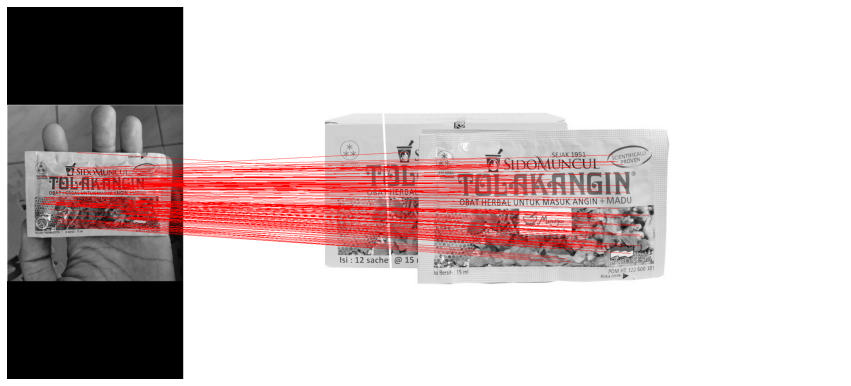

In [ ]:
# Use FLANN
MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 0
INDEX_PARAMS = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
SEARCH_PARAMS = dict(checks=50)

flann = cv2.FlannBasedMatcher(INDEX_PARAMS, SEARCH_PARAMS)
matches = flann.knnMatch(des_target, des_scene, k=2)

# Lowe's ratio test
good = []
for m,n in matches:
  if m.distance < 0.7 * n.distance:
    good.append(m)

if len(good) > MIN_MATCH_COUNT:
  # Estimate homography between template and scene
  src_pts = np.float32([ kp_target[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
  dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

  M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

  # Draw detected template in scene image
  h, w = img_target.shape
  pts = np.float32([[0, 0],
                    [0, h - 1],
                    [w - 1, h - 1],
                    [w - 1, 0]]).reshape(-1, 1, 2)
  dst = cv2.perspectiveTransform(pts, M)

  img2 = cv2.polylines(img_scene, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

  h1, w1 = img_target.shape
  h2, w2 = img_scene.shape
  nWidth = w1 + w2
  nHeight = max(h1, h2)
  hdif = int((h2 - h1) / 2)
  newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

  for i in range(3):
      newimg[hdif:hdif + h1, :w1, i] = img_target
      newimg[:h2, w1:w1 + w2, i] = img2

  # Draw SIFT keypoint matches
  for m in good:
      pt1 = (int(kp_target[m.queryIdx].pt[0]), int(kp_target[m.queryIdx].pt[1] + hdif))
      pt2 = (int(kp_scene[m.trainIdx].pt[0] + w1), int(kp_scene[m.trainIdx].pt[1]))
      cv2.line(newimg, pt1, pt2, (255, 0, 0))

  plt.figure(figsize=(15,15))
  plt.imshow(newimg)
  plt.axis('off')
  plt.show()
  
else:
  print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))

> From here we can see that we can match the feature between target image and scene image using `FLANN`

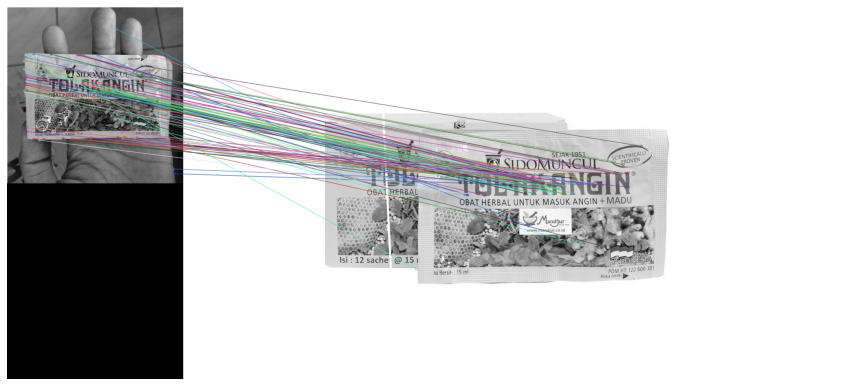

In [ ]:
# Use Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)
matches = bf.match(des_target, des_scene)
matches = sorted(matches, key = lambda x:x.distance)

img_bf = cv2.drawMatches(img_target, kp_target,
                         img_scene, kp_scene,
                         matches[:100], None,
                         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,15))
plt.imshow(img_bf)
plt.axis('off')
plt.show()

> From here we can see the feature matching using `BF Matcher`